# Tutorials

<div class="alert alert-info">

Note
    
This tutorial section is available as jupyter notebook in the `docs/` directory.

</div>

For all tutorials below we need to import mixsea and a few other libraries:

In [2]:
import mixsea as mx
import numpy as np
import matplotlib.pyplot as plt

## Read example CTD/LADCP profile

Read the example CTD and LADCP profiles from the test suite using a little helper function:

In [3]:
ctd = mx.helpers.read_ctd_testfile()
ladcp = mx.helpers.read_ladcp_testfile()

A quick overview plot of the data:

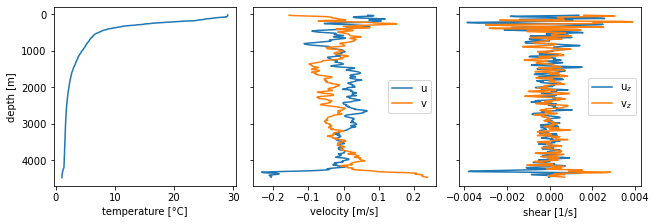

In [4]:
fig, ax = plt.subplots(nrows=1,
                           ncols=3,
                           figsize=(9, 3),
                           constrained_layout=True, 
                           sharey=True)
ax[0].plot(ctd['t'], ctd['z'])
ax[0].set(ylabel='depth [m]', xlabel='temperature [°C]')
ax[1].plot(ladcp['u'], ladcp['z'], label='u')
ax[1].plot(ladcp['v'], ladcp['z'], label='v')
ax[1].set(xlabel='velocity [m/s]')
ax[1].legend()
ax[2].plot(ladcp['uz'], ladcp['z'], label=r'u$_{z}$')
ax[2].plot(ladcp['vz'], ladcp['z'], label=r'v$_{z}$')
ax[2].set(xlabel='shear [1/s]')
ax[2].legend()
ax[0].invert_yaxis()

This is cast 81 from the 2012 Samoan Passage cruise. The layer of cold
Antarctic Bottom Water flowing through the Samoan Passage shows up in
temperature, velocity and shear. See <cite data-cite="voetetal15">Voet et al. (2015)</cite> for more information.

Now we have data on hand to apply mixing parameterizations below.

## Thorpe scales / overturns

A common practise when compiling observational data from ctd casts is to pad the top and/or bottom of profiles with NaN. This allows for convenient storage of many different length profiles in one 2D array. However, it also means we must constantly think about how to deal with NaN values in our data. This module contains a version of the Thorpe scale method that attempts to deal with NaN values in the most simple way possible, that is, it removes them before doing any calculations and then adds them back at the end. In many cases, such a simple approach will not be appropriate and could lead to erroneous results. As such, we highly recommend performing a quality control of your data prior to Thorpe scale analysis. In the example below we use `nan_eps_overturn` because our test data contain NaNs. If your data do not, then it is better to use `eps_overturn` directly. 

In [5]:
dnoise = 5e-4  # Noise parameter
alpha_sq = 0.9  # Square of the coefficient relating the Thorpe and Ozmidov scales.
# Background value of epsilon applied where no overturns are detected.
background_eps = np.nan
# Use the intermediate profile method
use_ip = True

eps, n2, diag = mx.overturn.nan_eps_overturn(
    ctd["p"],
    ctd["t"],
    ctd["s"],
    ctd["lon"][0],
    ctd["lat"][0],
    dnoise,
    alpha_sq,
    background_eps,
    use_ip=use_ip,
    return_diagnostics=True,
)

Lt = diag["Lt"]

Take a look at the result.

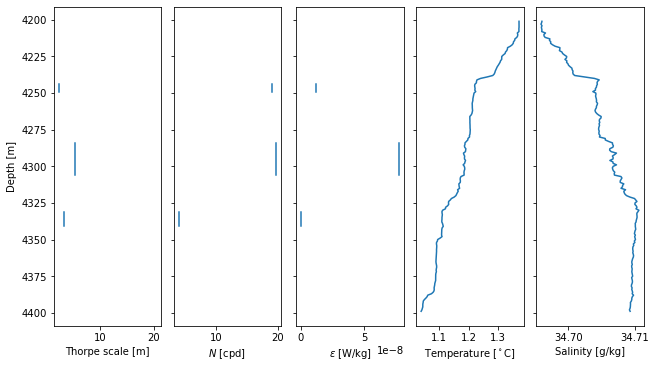

In [6]:
n = np.sqrt(n2) * (86400 / (2 * np.pi))  # Calculate buoyancy frequency in units of cpd.

# Plot only in the depth range:
cut = (ctd['z'] > 4200) & (ctd['z'] < 4400)
z = ctd['z'][cut]

fig, axs = plt.subplots(1, 5, sharey=True, constrained_layout=True, figsize=(9, 5))
axs[0].plot(Lt[cut], z)
axs[1].plot(n[cut], z)
axs[2].plot(eps[cut], z)
axs[3].plot(ctd["t"][cut], z)
axs[4].plot(ctd["s"][cut], z)
axs[0].invert_yaxis()
axs[0].set_ylabel("Depth [m]")
axs[0].set_xlabel("Thorpe scale [m]")
axs[1].set_xlabel(r"$N$ [cpd]")
axs[2].set_xlabel(r"$\epsilon$ [W/kg]")
axs[3].set_xlabel(r"Temperature [$^\circ$C]")
axs[4].set_xlabel("Salinity [g/kg]")
fig.align_labels()

## Shear/strain

Set up parameters for the shear/strain parameterization:

In [7]:
# Center points of depth windows. Windows are half overlapping, i.e.
# their size (200m) is double the spacing here (100m).
window_size = 200
dz = window_size / 2
print("window size {} m, window spacing {} m".format(window_size, dz))
zbin = np.linspace(dz, dz * 60, num=60)
# Wavenumber vector. Starts at wavenumber corresponding to a 200m
# wavelength.
m = np.arange(2 * np.pi / 200, 2 * np.pi / 10, 2 * np.pi / 200)
# Wavenumber indices for integration. Shear is integrated from 300m to
# 100m scales. Strain is integrated from 150m to 30m.
m_include_sh = list(range(3))
m_include_st = list(range(1, 12))

window size 200 m, window spacing 100.0 m


Now run the shear/strain parameterization:

In [9]:
eps_shst, krho_shst, diag = mx.shearstrain.shearstrain(
    ctd["s"],
    ctd["t"],
    ctd["p"],
    ctd["z"],
    ctd["lat"],
    ctd["lon"],
    ladcp["uz"],
    ladcp["vz"],
    ladcp["z"],
    m=m,
    z_bin=zbin,
    m_include_sh=m_include_sh,
    m_include_st=m_include_st,
    ladcp_is_shear=True,
    smooth="AL",
    return_diagnostics=True,
)

Plot the results:

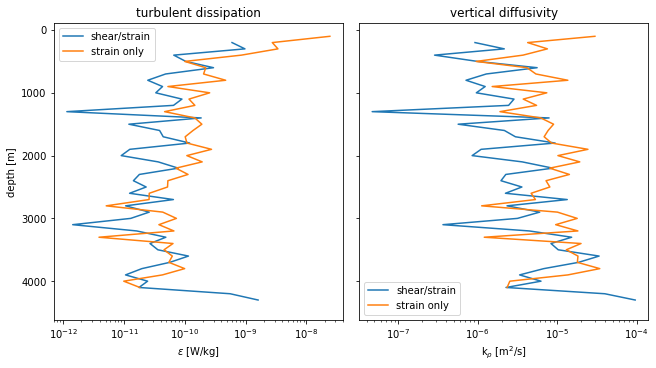

In [10]:
z_bin = diag['z_bin']
eps_st = diag['eps_st']
krho_st = diag['krho_st']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
constrained_layout=True, sharey=True)
ax[0].plot(eps_shst, z_bin, label='shear/strain');
ax[0].plot(eps_st, z_bin, label='strain only');
ax[0].legend()
ax[0].set(xscale='log', xlabel=r'$\epsilon$ [W/kg]', ylabel='depth [m]',
          title='turbulent dissipation');
ax[1].plot(krho_shst, z_bin, label='shear/strain');
ax[1].plot(krho_st, z_bin, label='strain only');
ax[1].legend();
ax[1].set(xscale='log', xlabel=r'k$_{\rho}$ [m$^2$/s]',
          title='vertical diffusivity');
ax[0].invert_yaxis()